<a href="https://colab.research.google.com/github/freAK14/TMLC-Fellowship/blob/main/Multiclass_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TMLC Fellowship Program Submission
## Name: Akash Kothare

[LinkedIn Profile](https://www.linkedin.com/in/akash-kothare/)

[GitHub Profile](https://github.com/freAK14)



# Importing Required Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image

import tarfile
import urllib
import os

In [2]:
IMAGES_URL = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
SETID_URL = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'
LABELS_URL = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
IMG_DIR = "jpg"
BASE_DIR = "."

#Downloading Data
Download and Extract .tgz file with .jpgs

In [3]:
if not os.path.exists(IMG_DIR):
    print('Downloading and extracting.')
    tfile = urllib.request.urlopen(IMAGES_URL)
    with tarfile.open(fileobj=tfile, mode='r|gz') as trfile:
        trfile.extractall()
    print("Done!")

Done!


### Vizualizing random images from the data

In [4]:
len(os.listdir("jpg"))
os.listdir("jpg")[0]

'image_02302.jpg'

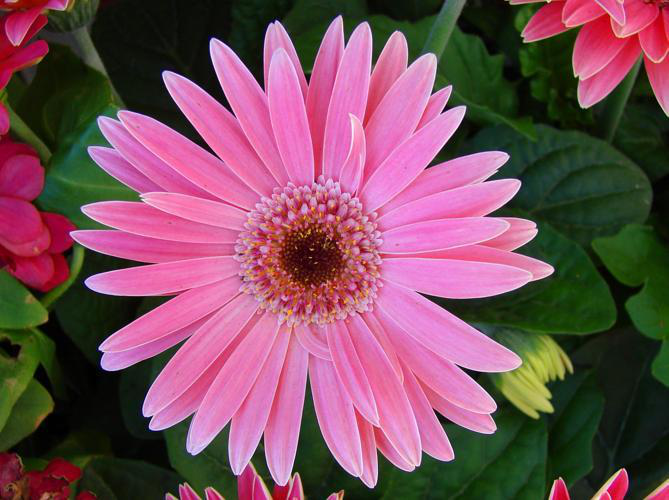

In [5]:
Image.open(os.path.join(IMG_DIR, os.listdir("jpg")[0]))

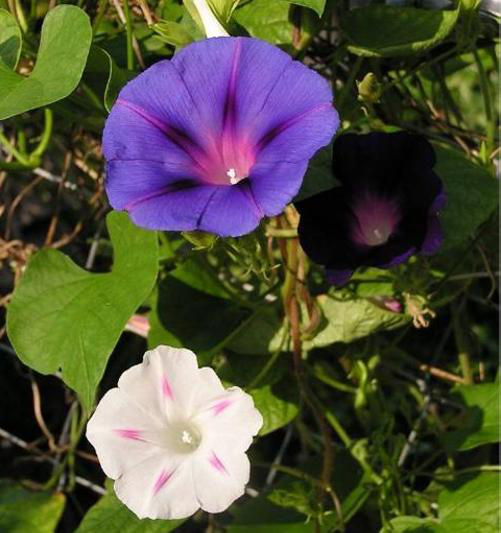

In [6]:
Image.open(os.path.join(IMG_DIR, os.listdir("jpg")[145]))

### Downloading image labels and the indices that split the whole dataset

In [7]:
setid_file = 'setid.mat'
imagelabels_name = 'imagelabels.mat'
urllib.request.urlretrieve(SETID_URL, os.path.join(BASE_DIR, setid_file))
urllib.request.urlretrieve(LABELS_URL, os.path.join(BASE_DIR, imagelabels_name))
setid = scipy.io.loadmat(setid_file)
labels = scipy.io.loadmat(imagelabels_name)


setid contains 3 arrays that split indices for train, val and test datasets

In [8]:
setid

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16)}

lables.labels contains the class numbers and is ordered just as indices hidden in filenames.

In [9]:
labels

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

# Data Preprocessing
Unique values for labels

In [10]:
np.unique(labels['labels'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102], dtype=uint8)

### Extracting index from a filename function

All file names have the same length and look like this: image_00853.jpg. The index number can be extracted by slicing the same part of the string with filename.

In [13]:
def get_index(fname):
  '''Slices the index number for a given filename and converts to int'''
  idx_str = fname[6:11]
  return int(idx_str)

### Converting images to Numpy Array function

I need a function that takes each file as parameter and saves it in the dataset with the index equal to the number in .jpg file name

In [15]:
DATA_LEN = len(os.listdir(IMG_DIR))
IMG_W = 100
IMG_H = 100
CHANNELS = 3

dataset = np.zeros((DATA_LEN, IMG_W, IMG_H, CHANNELS))

def reshape_img(fname):
    '''Reshapes and converts images to numpy array with values in range [0.0, 1.0]'''
    # get image using pillow
    img = Image.open(os.path.join(IMG_DIR, fname))
    # resize image
    img = img.resize((IMG_W, IMG_H))
    # convert image to numpy array in range [0.0, 1.0]
    img = np.asarray(img) / 255.0
    return img 

def save_to_dataset(img):
    np_img = reshape_img(img)
    i = get_index(img)
    dataset[i-1, :, :, :] = np_img

### Calling Data Preprocessing functions

In [16]:
%%time
for f in os.listdir(IMG_DIR):
    save_to_dataset(f)

CPU times: user 1min 6s, sys: 51.3 s, total: 1min 58s
Wall time: 1min 57s


In [17]:
dataset.shape

(8189, 100, 100, 3)

Getting the target values increased by one to get the range [0, 101]. This is necessary for the output Dense Layer

In [19]:
target = labels['labels'][0] - 1

In [20]:
np.max(target), np.min(target)

(101, 0)

In [21]:
setid['trnid'].shape, setid['tstid'].shape, setid['valid'].shape

((1, 1020), (1, 6149), (1, 1020))

I use permutation here, because there is no randomness in labels. They are already ordered. This means target[train_ids] looks like: [1, 1, 1, 1, ..., 2, 2, ..., 102, 102, 102]

setid['tstid'] has over 6k indices, so we'll use it as the training dataset

In [22]:
np.random.seed(31)
train_ids = np.random.permutation(setid['tstid'][0])
val_ids = np.random.permutation(setid['valid'][0])
test_ids = np.random.permutation(setid['trnid'][0])

The range of values for setid is [1, 8189]. The range of indices for our dataset array is [0, 8188]. This is why I subtract 1 for each index. Otherwise there will be IndexOutOfRange Exception

In [23]:
x_train, y_train = dataset[train_ids - 1], target[train_ids - 1].flatten()
x_val, y_val = dataset[val_ids -1], target[val_ids -1].flatten()
x_test, y_test = dataset[test_ids -1], target[test_ids -1].flatten()

# Data Augmentation using ImageDataGenerator

In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(height_shift_range=0.1, 
                             width_shift_range=0.1, 
                             horizontal_flip=True, 
                             zoom_range=0.1, 
                             rotation_range=20)

batch_size = 32
steps_per_epoch = x_train.shape[0] // batch_size

train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)

# Building the Image Classification Model from scratch

### Creating Layers and Initializing the Mode

In [25]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.regularizers import l2

inp_shape = x_train[0].shape
classes = np.unique(target).shape[0]

i = Input(shape=inp_shape)
x = Conv2D(32, (5, 5), activation='relu')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(classes, activation='softmax')(x)

bmodel = Model(i, x)

The CNN Architucture I built consists of 6 Convolutional Layers in total. All of them are separated with a Batch Norm Layers working as regularizers. After every second conv layer there is a MaxPool layer to reduce the dimensionality and keep only the strongest features.

In [27]:
bmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496 

# Training the Model

In [28]:
bmodel.compile(
    tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', metrics=['accuracy'])

basic = bmodel.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
192/192 [==============================] - 55s 122ms/step - loss: 8.4466 - accuracy: 0.0755 - val_loss: 7.3659 - val_accuracy: 0.0186
Epoch 2/30
192/192 [==============================] - 22s 117ms/step - loss: 5.1974 - accuracy: 0.1341 - val_loss: 5.8398 - val_accuracy: 0.0667
Epoch 3/30
192/192 [==============================] - 23s 117ms/step - loss: 4.4207 - accuracy: 0.1579 - val_loss: 4.5899 - val_accuracy: 0.1039
Epoch 4/30
192/192 [==============================] - 23s 117ms/step - loss: 3.9601 - accuracy: 0.1811 - val_loss: 4.0581 - val_accuracy: 0.1284
Epoch 5/30
192/192 [==============================] - 23s 117ms/step - loss: 3.6476 - accuracy: 0.2006 - val_loss: 3.8005 - val_accuracy: 0.1569
Epoch 6/30
192/192 [==============================] - 22s 117ms/step - loss: 3.4580 - accuracy: 0.2307 - val_loss: 3.6883 - val_accuracy: 0.2059
Epoch 7/30
192/192 [==============================] - 22s 117ms/step - loss: 3.3143 - accuracy: 0.2375 - val_loss: 4.6793 - val_ac

### Learning Curves

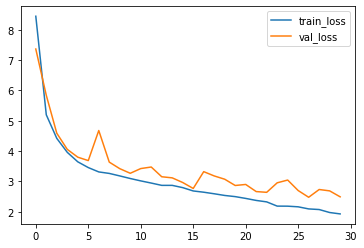

In [29]:
plt.plot(basic.history['loss'], label='train_loss')
plt.plot(basic.history['val_loss'], label='val_loss')
plt.legend();

### Evaluating on the test set

In [30]:
pred = bmodel.predict(x_test).argmax(axis=1)
bmodel.evaluate(x_test, y_test)

32/32 [==============================] - 1s 22ms/step - loss: 2.6161 - accuracy: 0.4598


[2.6160695552825928, 0.45980390906333923]

The model was trained on a set of over 6k images, which is considered to be a small data set. ~45% Accuracy on a completely new data after 30 epochs. This isn't bad at all if we consider, that random guessing would achieve Accuracy of ~1%. Looking at the Learning Curves I assume it could be possible to get some improvement if model kept training for some more epochs, since there is no clear overfitting yet.

# Transfer Learning using InceptionV3

Usually the best way to improve accuracy of a Deep Learning model is to gather more data and train it on a bigger dataset. Is there any solution if this isn't possible or is too expensive? Luckily, the answer is Yes. Using Convolutional Neural Networks it is possible to use very powerful models, that were trained Imagenet - a dataset containing millions of images with a 1000 classes. What is even better, with keras it is awfully easy to load those models. Let's use the one called Inception.



### Importing model and weights

In [31]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# this will download weights if needed
base_model = InceptionV3(weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


### Applying new fully connected layers

In base_model there is an Inception model stored with its weights. However, as already mentioned, this model was trained for a different classification task. How to use it in this project? The good news is, all there is to do is to adjust the fully connected part of the model to prepare it for our task. I.e. the convolutional part stays exactly how it was and get rid of the fully-connected part. To do it, I initialized the the Inception model with `include_top=False`

To train the model for the Flower Classification, the output layer must be the same as in the model that was built from scratch. The convolutional part will be completely reused and all the weights will be freezed with `layer.trainable=False`

In [32]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)
# add an output layer to our 102 classes
preds = Dense(102, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# train only the layers that we just added, since they are randomly initialized
# in other words freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

r = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=(x_val, y_val))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
192/192 [==============================] - 32s 134ms/step - loss: 3.2021 - accuracy: 0.2774 - val_loss: 2.5240 - val_accuracy: 0.3922
Epoch 2/20
192/192 [==============================] - 23s 121ms/step - loss: 2.1768 - accuracy: 0.4604 - val_loss: 2.0548 - val_accuracy: 0.4892
Epoch 3/20
192/192 [==============================] - 23s 118ms/step - loss: 1.9034 - accuracy: 0.5058 - val_loss: 1.9286 - val_accuracy: 0.5029
Epoch 4/20
192/192 [==============================] - 23s 119ms/step - loss: 1.7482 - accuracy: 0.5429 - val_loss: 1.7293 - val_accuracy: 0.5451
Epoch 5/20
192/192 [==============================] - 23s 118ms/step - loss: 1.6562 - accuracy: 0.5658 - val_loss: 1.6821 - val_accuracy: 0.5745
Epoch 6/20
192/192 [==============================] - 24s 125ms/step - loss: 1.5301 - accuracy: 0.5939 - val_loss: 1.6758 - val_accuracy: 0.5735
Epoch 7/20
192/192 [==============================] - 23s 121ms/step - loss: 1.4837 - accuracy: 0.5956 - val_loss: 1.6514 - val_ac

We achieved ~60% accuracy on a validation set after 20 epochs of training the weights from fully-connected layers. The convolutional part stayed exactly the same. What is quite remarkable, is that after only first 3 epochs this model already outperformed our model built from scratch!

### Fine Tuning

At this point, the weights in the fully-connected part are well trained. The accuracy is already ~15% better than in model built from scratch. And all of this without touching the convolutional part. So let's see what happens, when we unfreeze some of Convolutional Layers. The point is to create some feature maps that are better adjusted to our task. This method of improving performance is known as Fine Tuning.

In [33]:
# print all layers from base_model
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_6
2 batch_normalization_6
3 activation
4 conv2d_7
5 batch_normalization_7
6 activation_1
7 conv2d_8
8 batch_normalization_8
9 activation_2
10 max_pooling2d_3
11 conv2d_9
12 batch_normalization_9
13 activation_3
14 conv2d_10
15 batch_normalization_10
16 activation_4
17 max_pooling2d_4
18 conv2d_14
19 batch_normalization_14
20 activation_8
21 conv2d_12
22 conv2d_15
23 batch_normalization_12
24 batch_normalization_15
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_11
29 conv2d_13
30 conv2d_16
31 conv2d_17
32 batch_normalization_11
33 batch_normalization_13
34 batch_normalization_16
35 batch_normalization_17
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_21
42 batch_normalization_21
43 activation_15
44 conv2d_19
45 conv2d_22
46 batch_normalization_19
47 batch_normalization_22
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_18
52 conv2d_20
53 conv2d_23
54 conv2d_24
55 batch_normalization_18
56 batch_

Inception model consists of blocks. They are separated with layers called mixed. For Fine Tuning let's unfreeze the last 3 blocks to train them on our training data.

In [35]:
# the last 3 blocks begin at the 229th layer
# let's unfreeze them
for layer in model.layers[:229]:
   layer.trainable = False
for layer in model.layers[229:]:
   layer.trainable = True

# recompiling the model, so our changes take place
# using Adative Moment Estimation with a low learning ratee
model.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the last 3 convolutional Layers along with fully connected ones
r = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
192/192 [==============================] - 32s 140ms/step - loss: 1.7693 - accuracy: 0.5313 - val_loss: 1.7531 - val_accuracy: 0.5853
Epoch 2/20
192/192 [==============================] - 24s 126ms/step - loss: 1.3115 - accuracy: 0.6397 - val_loss: 1.7280 - val_accuracy: 0.6108
Epoch 3/20
192/192 [==============================] - 24s 127ms/step - loss: 1.1535 - accuracy: 0.6824 - val_loss: 1.5117 - val_accuracy: 0.6461
Epoch 4/20
192/192 [==============================] - 25s 128ms/step - loss: 0.9770 - accuracy: 0.7236 - val_loss: 2.1627 - val_accuracy: 0.6137
Epoch 5/20
192/192 [==============================] - 25s 128ms/step - loss: 0.9798 - accuracy: 0.7221 - val_loss: 1.2669 - val_accuracy: 0.6814
Epoch 6/20
192/192 [==============================] - 24s 127ms/step - loss: 0.8673 - accuracy: 0.7513 - val_loss: 1.1934 - val_accuracy: 0.7029
Epoch 7/20
192/192 [==============================] - 24s 126ms/step - loss: 0.7707 - accuracy: 0.7777 - val_loss: 1.1768 - val_ac

### Learning curves

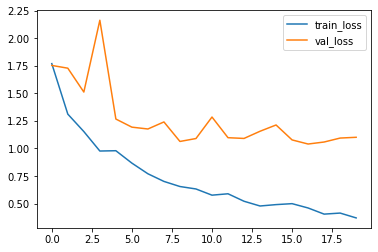

In [36]:
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

### Evaluating on the test set

In [37]:
pred = model.predict(x_test).argmax(axis=1)
model.evaluate(x_test, y_test)

32/32 [==============================] - 2s 58ms/step - loss: 1.2798 - accuracy: 0.7206


[1.27975594997406, 0.720588207244873]

72% accuracy after 15 minutes of training in total. However, there is not too much improvement after 5th epoch and there is clearly overfitting. Transfer learning does work :)

### Saving the model

In [38]:
model.save('model.h5')

# Summary

The goal behind creating this Notebook was to build CNN models that perform an Image Classification task on the given Flower 102 dataset. Two different models were trained:


*   a model built from scratch and trained only on the train set used in this project
*   a model that applies Transfer Learning using Inception model trained on millions of images, but for a different classification task

After comparing the accuracy, it is clear that for this dataset the model that uses Transfer Learning can categorize much better and strongly outperforms the former model. Luckily, Keras API already has some pretrained, very powerful models that are ready to download. Building a model using Transfer Learning is just as easy as building one from scratch.
